<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Orthogonal Random Forest: Use Cases and Examples

Orthogonal Random Forest (ORF) combines orthogonalization,
a technique that effectively removes the confounding effect in two-stage estimation,
with generalized random forests, a flexible method for estimating treatment effect heterogeneity. Due to the orthogonalization aspect of this method, the ORF performs especially well in the presence of high-dimensional confounders. For more details, see [this paper](https://arxiv.org/abs/1806.03467) or the [EconML docummentation](https://econml.azurewebsites.net/).

The EconML SDK implements the following OrthoForest variants:

* ContinuousTreatmentOrthoForest: suitable for continuous treatments

* DiscreteTreatmentOrthoForest: suitable for discrete treatments

In this notebook, we show the performance of the ORF on synthetic and observational data. 

## Notebook Contents

1. [Example Usage with Continuous Treatment Synthetic Data](#1.-Example-Usage-with-Continuous-Treatment-Synthetic-Data)
2. [Example Usage with Binary Treatment Synthetic Data](#2.-Example-Usage-with-Binary-Treatment-Synthetic-Data)
3. [Example Usage with Multiple Treatment Synthetic Data](#3.-Example-Usage-with-Multiple-Treatment-Synthetic-Data)
4. [Example Usage with Real Continuous Treatment Observational Data](#4.-Example-Usage-with-Real-Continuous-Treatment-Observational-Data)

In [1]:
import econml
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Main imports
from econml.ortho_forest import ContinuousTreatmentOrthoForest, DiscreteTreatmentOrthoForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Example Usage with Continuous Treatment Synthetic Data

## 1.1 DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [3]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

In [4]:
# DGP constants
np.random.seed(123)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)
# Treatment support 
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# ORF parameters and test data
subsample_ratio = 0.3
lambda_reg = np.sqrt(np.log(n_w) / (10 * subsample_ratio * n))
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

## 1.2. Train Estimator

**Note:** The models in the final stage of the estimation (``model_T_final``, ``model_Y_final``) need to support sample weighting. 

If the models of choice do not support sample weights (e.g. ``sklearn.linear_model.LassoCV``), the ``econml`` packages provides a convenient wrapper for these models ``WeightedModelWrapper`` in order to allow sample weights.

In [5]:
est = ContinuousTreatmentOrthoForest(
    n_trees=200, min_leaf_size=5,
    max_depth=50, subsample_ratio=subsample_ratio,
    model_T=Lasso(alpha=lambda_reg),
    model_Y=Lasso(alpha=lambda_reg),
    model_T_final=WeightedLasso(alpha=lambda_reg),
    model_Y_final=WeightedLasso(alpha=lambda_reg),
    random_state=123)

To use the built-in confidence intervals constructed via Bootstrap of Little Bags, we need to specify `inference="blb"` at `fit` time.

In [6]:
est.fit(Y, T, X, W, inference="blb")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:   10.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished


In [7]:
# Calculate treatment effects
treatment_effects = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished


In [8]:
# Calculate default (90%) confidence intervals for the test data
te_lower, te_upper = est.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


## 1.3. Performance Visualization

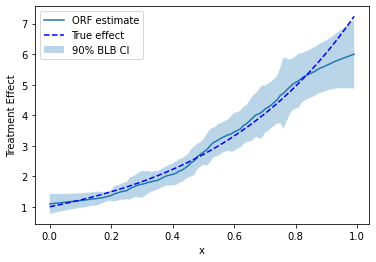

In [9]:
plt.plot(X_test, treatment_effects, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower, te_upper, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

# 2. Example Usage with Binary Treatment Synthetic Data

## 2.1. DGP 
We use the following DGP:

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta, \gamma$ have high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = \exp( 2\cdot x_1 ).
\end{align}

In [10]:
# DGP constants
np.random.seed(1234)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)
# Treatment support 
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# ORF parameters and test data
subsample_ratio = 0.4
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

## 2.2. Train Estimator 

In [11]:
est = DiscreteTreatmentOrthoForest(
    n_trees=200, min_leaf_size=10,
    max_depth=30, subsample_ratio=subsample_ratio,
    propensity_model = LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
    model_Y = Lasso(alpha=lambda_reg),
    propensity_model_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
    model_Y_final=WeightedLasso(alpha=lambda_reg)
)

In [12]:
est.fit(Y, T, X, W, inference="blb")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:   11.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished


In [13]:
# Calculate treatment effects for the default treatment points T0=0 and T1=1
treatment_effects = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished


In [14]:
# Calculate default (90%) confidence intervals for the default treatment points T0=0 and T1=1
te_lower, te_upper = est.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


## 2.3. Performance Visualization

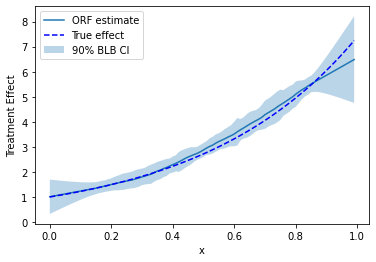

In [15]:
# Smaller slices
y = treatment_effects
plt.plot(X_test, y, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower, te_upper, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

# 3. Example Usage with Multiple Treatment Synthetic Data

## 3.1. DGP 
We use the following DGP:

\begin{align}
Y = & \sum_{t=1}^{n_{\text{treatments}}} 1\{T=t\}\cdot \theta_{T}(X) + \langle W, \gamma\rangle + \epsilon, \; \epsilon \sim \text{Unif}(-1, 1), \\
\text{Pr}[T=t \mid W] \propto & \exp\{\langle W, \beta_t \rangle\}, \;\;\;\; \forall t\in \{0, 1, \ldots, n_{\text{treatments}}\} 
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta_t, \gamma$ are sparse.

For this particular example DGP we used $n_{\text{treatments}}=3$ and 
\begin{align}
\theta_1(x) = & \exp( 2 x_1 ),\\
\theta_2(x) = &  3 \cdot \sigma(100\cdot (x_1 - .5)),\\
\theta_3(x) = & -2 \cdot \sigma(100\cdot (x_1 - .25)),
\end{align}
where $\sigma$ is the sigmoid function.

In [16]:
def get_test_train_data(n, n_w, support_size, n_x, te_func, n_treatments):
    # Outcome support
    support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)
    # Treatment support 
    support_T = support_Y
    coefs_T = np.random.uniform(0, 1, size=(support_size, n_treatments))
    eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 
    # Generate controls, covariates, treatments and outcomes
    W = np.random.normal(0, 1, size=(n, n_w))
    X = np.random.uniform(0, 1, size=(n, n_x))
    # Heterogeneous treatment effects
    TE = np.array([te_func(x_i, n_treatments) for x_i in X])
    log_odds = np.dot(W[:, support_T], coefs_T)
    T_sigmoid = np.exp(log_odds)
    T_sigmoid = T_sigmoid/np.sum(T_sigmoid, axis=1, keepdims=True)
    T = np.array([np.random.choice(n_treatments, p=p) for p in T_sigmoid])
    TE = np.concatenate((np.zeros((n,1)), TE), axis=1)
    Y = TE[np.arange(n), T] + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
    X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

    return (Y, T, X, W), (X_test, np.array([te_func(x, n_treatments) for x in X_test]))

In [17]:
import scipy.special
def te_func(x, n_treatments):
    return [np.exp(2*x[0]), 3*scipy.special.expit(100*(x[0] - .5)) - 1, -2*scipy.special.expit(100*(x[0] - .25))]

np.random.seed(123)
(Y, T, X, W), (X_test, te_test) = get_test_train_data(2000, 3, 3, 1, te_func, 4)

## 3.2. Train Estimator

In [18]:
est = DiscreteTreatmentOrthoForest(n_trees=500,
                                   model_Y = WeightedLasso(alpha=lambda_reg))

In [19]:
est.fit(Y, T, X, W, inference="blb")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.7s finished


In [20]:
# Calculate marginal treatment effects
treatment_effects = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


In [21]:
# Calculate default (90%) marginal confidence intervals for the test data
te_lower, te_upper = est.const_marginal_effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


## 3.3. Performance Visualization

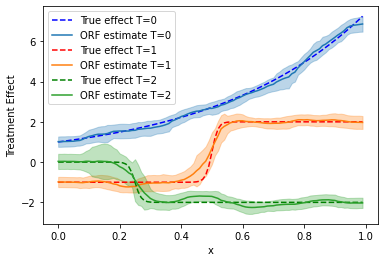

In [22]:
y = treatment_effects
colors = ['b', 'r', 'g']
for it in range(y.shape[1]):
    plt.plot(X_test[:, 0], te_test[:, it], '--', label='True effect T={}'.format(it), color=colors[it])
    plt.fill_between(X_test[:, 0], te_lower[:, it], te_upper[:, it], alpha=0.3, color='C{}'.format(it))
    plt.plot(X_test, y[:, it], label='ORF estimate T={}'.format(it), color='C{}'.format(it))
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

# 4. Example Usage with Real Continuous Treatment Observational Data

We applied our technique to Dominick’s dataset, a popular historical dataset of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

The dataset is comprised of a large number of covariates $W$, but researchers might only be interested in learning the elasticity of demand as a function of a few variables $x$ such
as income or education. 

We applied the `ContinuousTreatmentOrthoForest` to estimate orange juice price elasticity
as a function of income, and our results, unveil the natural phenomenon that lower income consumers are more price-sensitive.

## 4.1. Data

In [23]:
# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [24]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [25]:
# Prepare data
Y = oj_data['logmove'].values
T = np.log(oj_data["price"]).values
scaler = StandardScaler()
W1 = scaler.fit_transform(oj_data[[c for c in oj_data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store']]].values)
W2 = pd.get_dummies(oj_data[['brand']]).values
W = np.concatenate([W1, W2], axis=1)
X = oj_data[['INCOME']].values

## 4.2. Train Estimator

In [26]:
# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [27]:
est = ContinuousTreatmentOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio,
        model_T=Lasso(alpha=0.1),
        model_Y=Lasso(alpha=0.1),
        model_T_final=WeightedLassoCVWrapper(cv=3), 
        model_Y_final=WeightedLassoCVWrapper(cv=3)
       )

In [28]:
est.fit(Y, T, X, W, inference="blb")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 880 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   34.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.6s finished


In [29]:
min_income = 10.0 
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

In [30]:
# Calculate marginal treatment effects
treatment_effects = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  1.3min finished


In [31]:
# Calculate default (90%) marginal confidence intervals for the test data
te_upper, te_lower = est.const_marginal_effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   25.2s finished


## 4.3. Performance Visualization

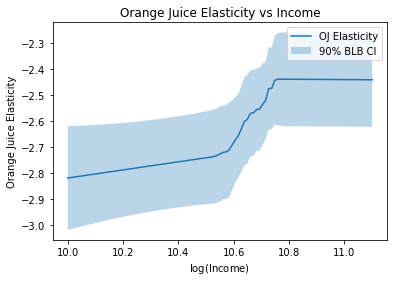

In [32]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test.flatten(), treatment_effects, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_lower, te_upper, label="90% BLB CI", alpha=0.3)
plt.xlabel(r'$\log$(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()